# Dart Target 

## Description

Detect the coordinates of this dart target center


## Group ID

Group 13
Nelson José Marques Martins Almeida pg52697 
Carlos Gustavo Pereira pg53723

In [226]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

## Lets start by importing our image

(708, 1052)


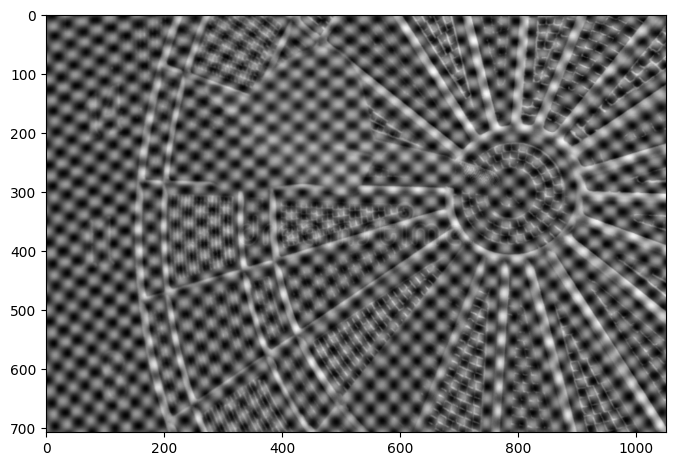

In [287]:
fname = 'DartTarget-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

### We can easily verify that the image has a Moiré pattern that inhibts us from locating the bullseye
#### To correct this we will use the magnitude spectrum of the image

Text(0.5, 1.0, 'Magnitude Spectrum')

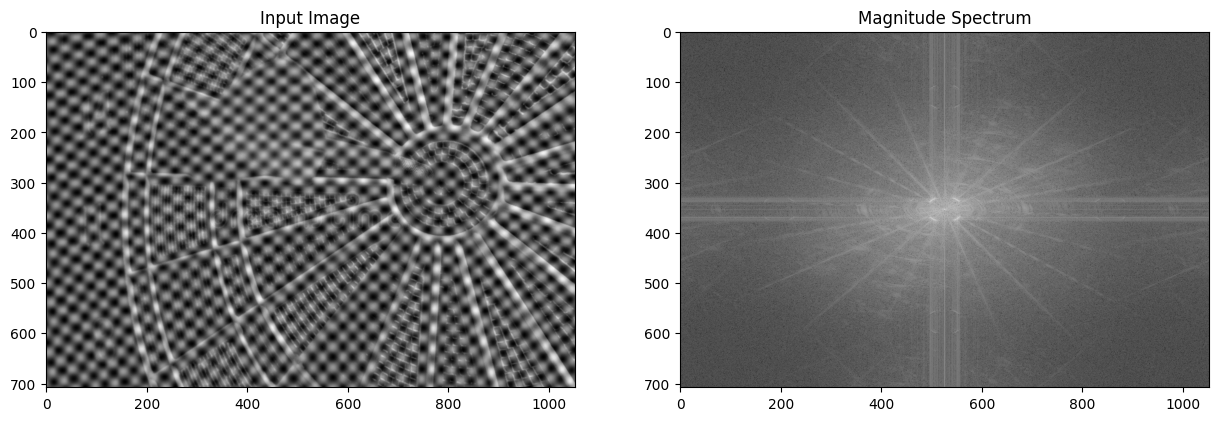

In [288]:
# Convert the image representation to SPFP
img_float = np.float32(img)

#Lets calculate the Discrete Fourier Transform of the image
dft = cv2.dft(img_float, flags = cv2.DFT_COMPLEX_OUTPUT)
#Center the DFT in (0,0)
dft_shift = np.fft.fftshift(dft)
#Calculate the magnitude spectrum
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
#Apply the logarithmic function to enchance the visualization of the darker pixels
magnitude_spectrum = 20*np.log(magnitude_spectrum) 

f, axarr = plt.subplots(1,2,figsize=(15,15*ratio))
axarr[0].imshow(img, cmap='gray')
axarr[0].set_title('Input Image')
axarr[1].imshow(magnitude_spectrum, cmap='gray')
axarr[1].set_title('Magnitude Spectrum')

### In order to find the hotspots of the image we will get the 99th percentile, this way we can ensure that we get the brightests spots from the image

In [310]:

hotspots = []
averageLightning = np.percentile(magnitude_spectrum, 99.5)

# Detect the hotspots in the image, neglecting the center
#We only consider the top-left quadrant of the magnitude spectrum since the magnitude spectrum is reflected in all axis
for i in range(1, magnitude_spectrum.shape[0] // 2):
    for j in range(1, magnitude_spectrum.shape[1] // 2):
        if magnitude_spectrum[i][j] >= averageLightning:
            hotspots.append((i, j))


#This "bruteforce"" algorithm shrinks the number of hotspots until it finds the desired number of hotspots by altering the delta value
#The delta value is the distance between the hotest spots found previously
def bruteforce_search(magnitude_spectrum, hotspots, target=1):
    #/*TODO: Implement a logarithmic step to reduce the number of hotspots*/
    hotspotsBoxes = hotspots
    box = []
    delta = 0
    while(len(hotspotsBoxes) > target):
        box=[]
        hotspotsBoxes=[]
        for i in range(len(hotspots) - 1):
            #exclude the points near the center since it will be the main hotspot
            if abs(hotspots[i][0]-magnitude_spectrum.shape[0]//2) < 10 and abs(hotspots[i][1]-magnitude_spectrum.shape[1]//2) < 10:
                continue
            elif abs(hotspots[i][0] - hotspots[i + 1][0]) < delta and abs(hotspots[i][1] - hotspots[i + 1][1]) < delta :
                box.append(hotspots[i])
            else:
                box.append(hotspots[i])
                hotspotsBoxes.append(box)
                box = []
        delta += 0.5

    #Here we box the hotspots and select the one with the highest lightning
    hotspotPerBox = []
    for box in hotspotsBoxes:
        maxLightning = 0
        hotpostIndex = 0
        for i in range(len(box)):
            if magnitude_spectrum[box[i][0]][box[i][1]] > maxLightning:
                maxLightning = magnitude_spectrum[box[i][0]][box[i][1]]
                hotpostIndex = i
        hotspotPerBox.append(box[hotpostIndex])
   
    return hotspotPerBox

hotspots = bruteforce_search(magnitude_spectrum, hotspots=hotspots, target=1)


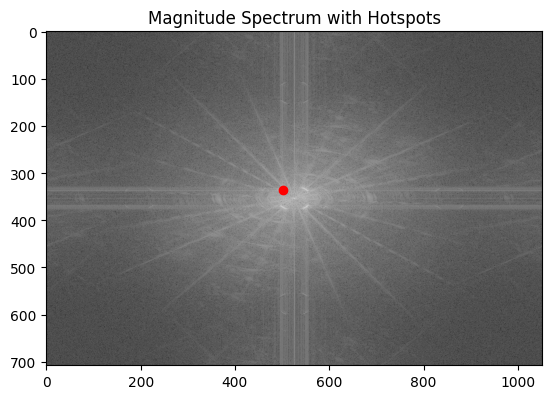

In [311]:
#Lets plot the discovered hotspots
x = [hotspot[1] for hotspot in hotspots]
y = [hotspot[0] for hotspot in hotspots]
plt.scatter(x, y, color='red')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum with Hotspots')
plt.show()

### As we can see, we found the correct spot of the hotspot in the magnitude spectrum of the image
#### Now we have to determine the ghosts of said hotspots

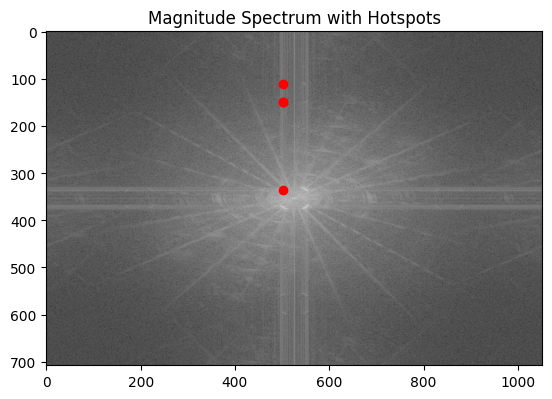

In [318]:
#/*TODO:*/ determine the apropriate notch filter shape/radius


#Determine the ghosts
threshold = 127
#First step is to threshold the image so we can detect the ghosts easier since in the current state their identification is not clear
magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
ret,th1 = cv2.threshold(magnitude_spectrum,threshold,255,cv2.THRESH_BINARY)

#In the following code we will detect the ghosts by looking for the first pixel with a higher lightning than the threshold
hotspotsGhosts = {}
for hotspot in hotspots:

    hotspotsGhosts[hotspot] = []
    x = hotspot[1]
    y = hotspot[0]
    ghostFound = False
    #We will start from the top of the image and go down until we find the first ghost
    #If we find a ghost and then we find another ghost below it by 2*y+delta, then we have found a "full ghost"
    #Else the other "piece" of the ghost is out of bounds

    for y1 in range(0,y):
        averageLightning = np.average([th1[y1][x1] for x1 in range(x-2,x+2)])
        if averageLightning > threshold:
            hotspotsGhosts[hotspot].append((y1,x))
            ghostFound=True
            break

    distanceToCenter = abs(y-th1.shape[0]//2)
    if ghostFound:
        #If the ghost was found then we have to verify if there is another piece of the ghost in 2*y+delta
        #If the distance to verify is equal to the original ghost, then it is a full ghost
        #Else it may be "lost" or out of bounds
        delta=5
        for i in range(y1+2*(distanceToCenter), y1+2*(distanceToCenter)+delta):
            averageLightning = np.average([th1[i][x1] for x1 in range(x-2,x+2)])
            if averageLightning > threshold:
                hotspotsGhosts[hotspot].append((i,x))
                secondGhostx = x
                secondGhosty = i
        
                break
    
    
for hotspot in hotspotsGhosts:
    plt.scatter(hotspot[1], hotspot[0], color='red')
    for (y,x) in hotspotsGhosts[hotspot]:
        plt.scatter(x, y, color='red')
plt.scatter(secondGhostx, secondGhosty, color='red')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum with Hotspots')
plt.show()


In [319]:

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

In [328]:
#Lets apply notch filters to the hotspots and see the result
#We will apply notch filters in all axis(colocar esta dúvida ao professor)
d0_list = []
u_k_list = []
v_k_list = []

#U=x
#V=y

for i in hotspots:
    xDistanceToCenter = abs((img.shape[1]//2)-i[1])
    yDistanceToCenter = abs((img.shape[0]//2)-i[0])

    d0_list.append(9)
    d0_list.append(9)
    
    v_k_list.append(-xDistanceToCenter)
    v_k_list.append(xDistanceToCenter)

    u_k_list.append(yDistanceToCenter)
    u_k_list.append(yDistanceToCenter)
    #The following code will apply the notch filter to the ghosts
    #We will apply a smaller notch filter to the ghosts in order to minimize the loss of information
    for j in hotspotsGhosts[i]:   
        yDistanceToCenter = abs((img.shape[0]//2)-j[0])

        d0_list.append(9//2)
        d0_list.append(9//2)

        v_k_list.append(-xDistanceToCenter)
        v_k_list.append(xDistanceToCenter)

        u_k_list.append(yDistanceToCenter)
        u_k_list.append(yDistanceToCenter)



H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)
    H *= Haux


# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [329]:
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

In [330]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

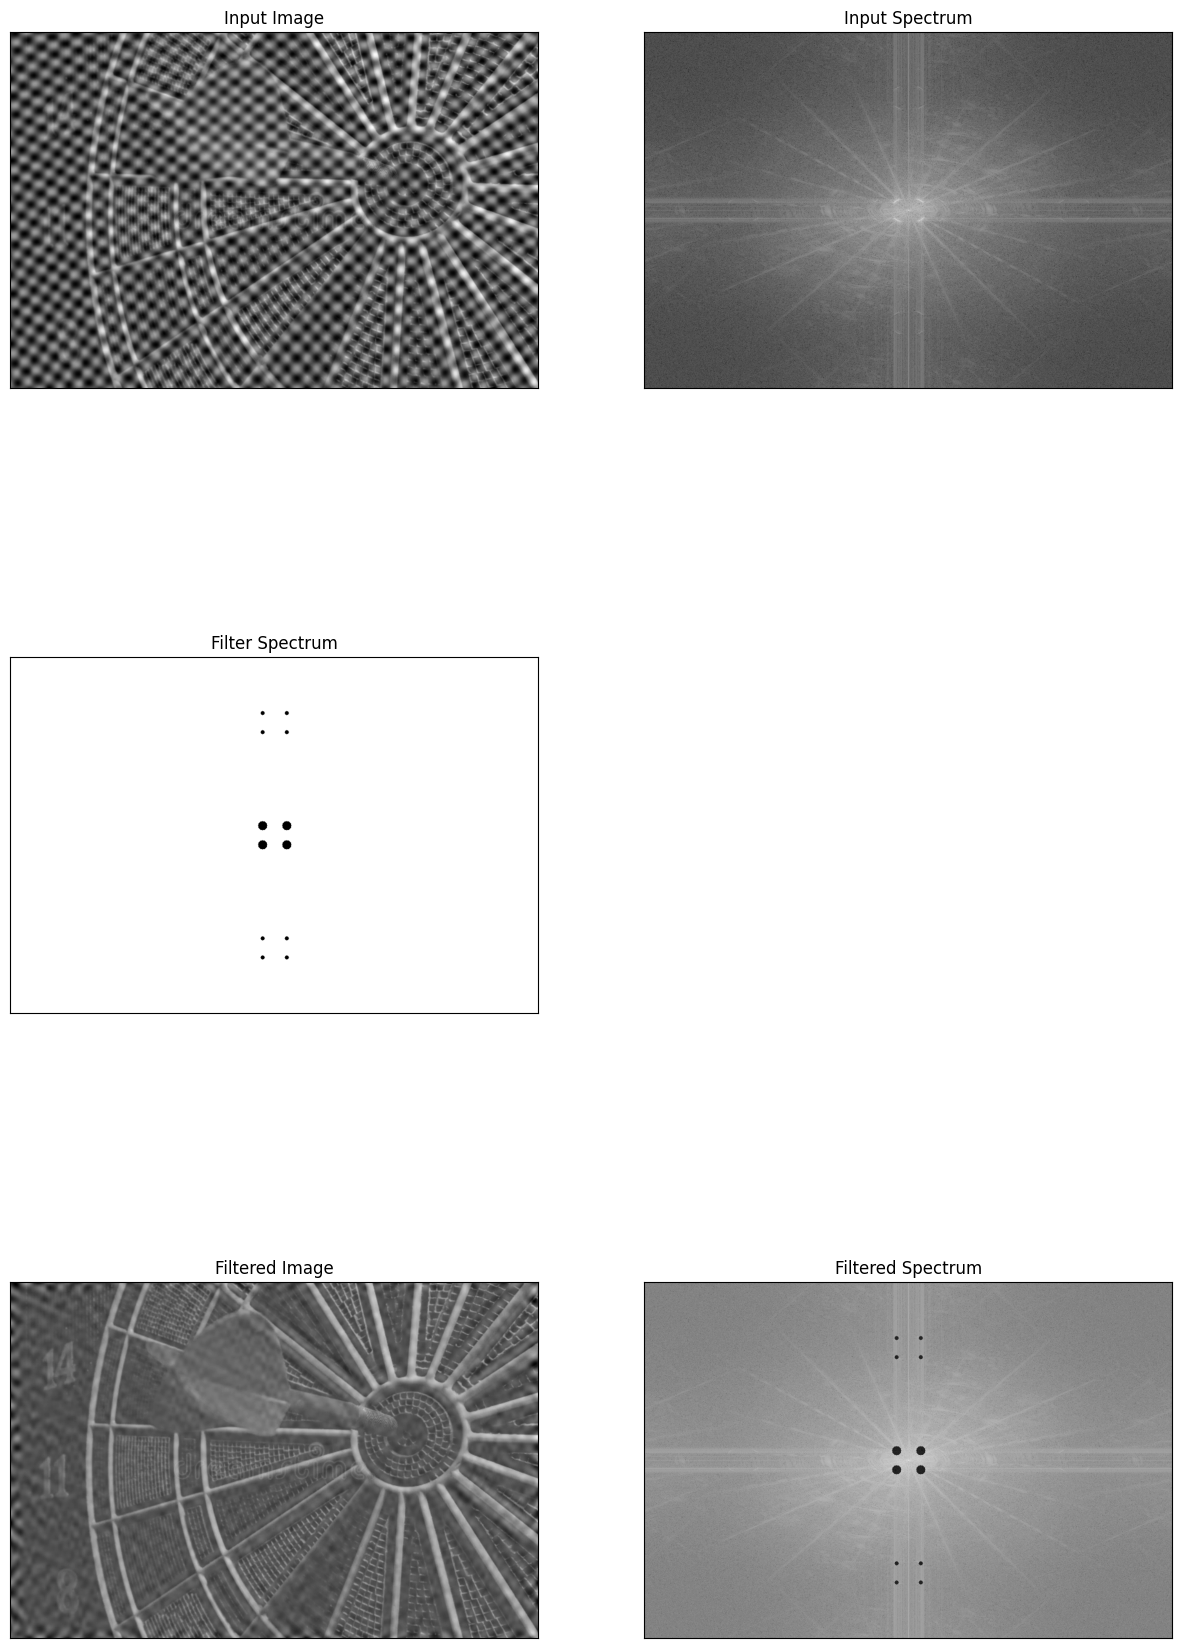

In [331]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])

plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         

### Now that we have reduced the Moiré effect noise we can try to identify the bullseye
#### To achieve this we will threshold the image and apply a average based filter to eliminate the noise generated by the unwanted elements from the backboard. We want to keep only the structure/rim of the dart board

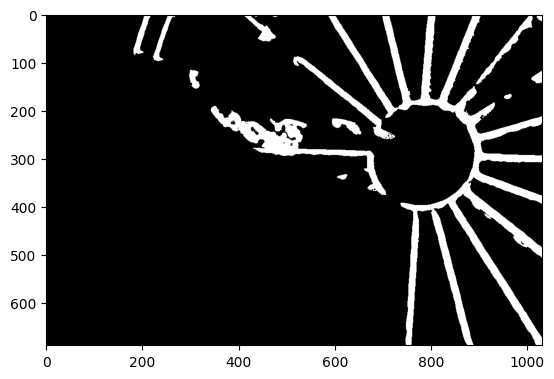

In [332]:
img_clean = img_back.copy()

# Normalize the image
img_clean = cv2.normalize(img_clean, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

_, img_clean = cv2.threshold(img_clean, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Lets apply a filter to try to remove the backboard from the image
#For each pixel, if the average of its neighbours is lower than a threshold, then we will set it to 0
#This will remove the backboard from the image
for i in range(9, img_clean.shape[0] - 9):
    for j in range(9, img_clean.shape[1] - 9):
        if np.average(img_clean[i-9:i+9, j-9:j+9]) < 120:
            img_clean[i, j] = 0

#Remove the borders
img_clean = img_clean[10:-10, 10:-10]

# for i in range(9, img_clean.shape[0] - 9):
#     for j in range(9, img_clean.shape[1] - 9):
#         if np.average(img_clean[i-9:i+9, j-9:j+9]) < 120:
#             img_clean[i, j] = 0
            

plt.imshow(img_clean, cmap='gray')
img2 = img_clean.copy()

### Now that we have an image that only has the circle that we want we will apply the Hough Circles function provided by the OpenCV library.
#### This function is based in the Hough Transform but directed to finding circles in images

2


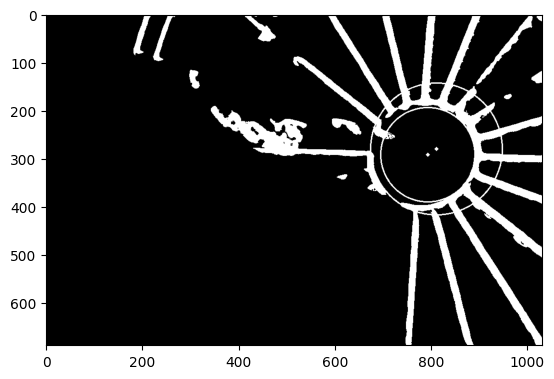

In [333]:
#Lets apply the Hough Circle Transform to detect the circles in the image
#The parameters are the following:
#img2 - the input image
#cv2.HOUGH_GRADIENT - the method to detect the circles
#3 - The inverse ratio of the accumulator resolution to the image resolution
#10 - The minimum distance between the centers of the detected circles
#param1 - The higher threshold of the two passed to the Canny edge detector
#param2 - The accumulator threshold for the circle centers at the detection stage
#minRadius - The minimum radius of the circles to detect
#maxRadius - The maximum radius of the circles to detect
## We fine tuned this parameters to achieve the best results, we set the minimum radius to five to neglect the smaller circles that can come from the noise of the image like the remaining of the dart flight
circles = cv2.HoughCircles(img2, cv2.HOUGH_GRADIENT,
                            3, 10, 
                            param1=1000, param2=150, 
                            minRadius=5, maxRadius=img_clean.shape[0]//4)

#Draw the circles
if circles is not None:
    print(len(circles[0]))
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # draw the outer circle
        cv2.circle(img2, (i[0], i[1]), i[2], (255, 0, 0), 2)
        # draw the center of the circle
        cv2.circle(img2, (i[0], i[1]), 2, (255, 0, 0), 3)
#plot the image
plt.imshow(img2, cmap='gray')
plt.show()

### As we can see from the drawing above the result is made by two circles, but both of them circundate the goal so we average their coordinates to get the aproximate the center

In [334]:
#Lets get the center by averaging the found circles
center = (np.average(circles[0, :, 0]), np.average(circles[0, :, 1]))
print(center)


(803.0, 286.0)


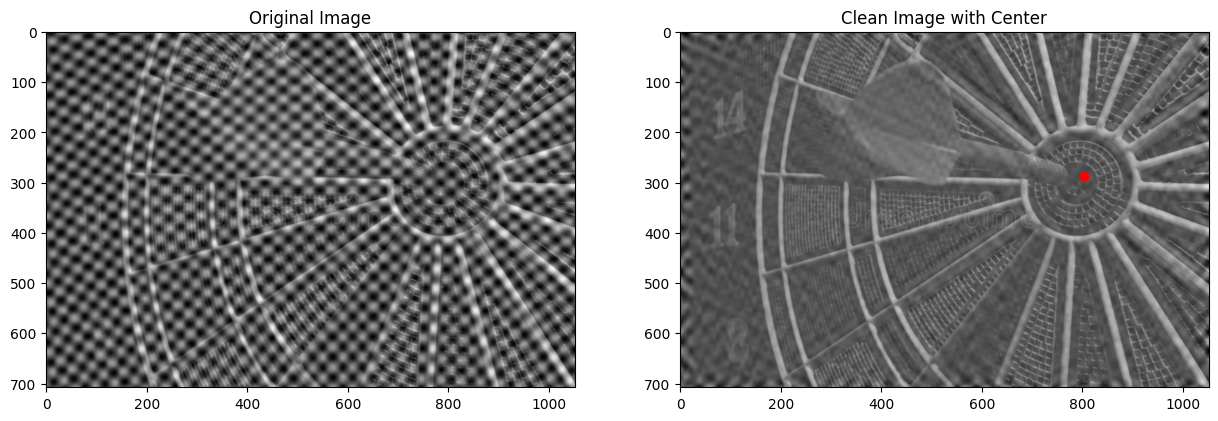

In [335]:
#Lets plot the clean image and the center that we discovered
f, axarr = plt.subplots(1,2,figsize=(15,15*ratio))
axarr[0].imshow(img, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(img_back, cmap='gray')
axarr[1].set_title('Clean Image with Center')
plt.scatter(center[0], center[1], color='red')
plt.show()